# Libraries

In [19]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, ReLU, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Load data

In [ ]:
def unpickle_class_names():
    with open('data/meta', 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
    fine_class_names = [name.decode('utf-8') for name in meta_data[b'fine_label_names']]
    return fine_class_names

def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def split_dict(dict):
    image = dict[b'data']
    fine_labels = np.array(dict[b'fine_labels'])
    return image, fine_labels

def preprocess_images(images):
    images = images.reshape((-1, 3, 32, 32))
    images = images.transpose((0, 2, 3, 1))
    images = images.astype('float32') / 255.0
    return images

In [ ]:
train_data = unpickle('/content/data/train')
test_data = unpickle('/content/data/test')
fine_names = unpickle_class_names()

In [ ]:
train_images, train_fine = split_dict(train_data)
test_images, test_fine = split_dict(test_data)

In [ ]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

## Show data

In [ ]:
def show_random(images, fine, num_images=4):
    idxs = np.random.choice(len(images), num_images, replace=False)
    rows = cols = int(np.ceil(np.sqrt(num_images)))
    plt.figure(figsize=(rows * 3, cols * 3))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        plt.title(f'{fine_names[fine[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


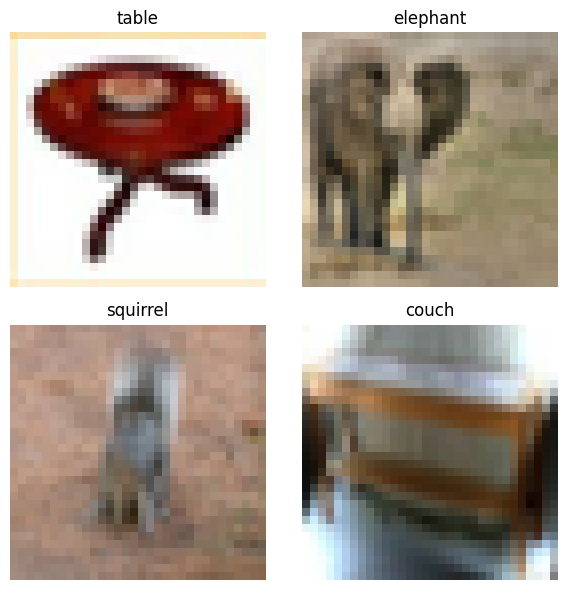

In [ ]:
show_random(train_images, train_fine)

# Train

## Residual Block

In [3]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters=64, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.stride = stride
        self.conv1 = Conv2D(filters, 3, strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters, 3, strides=1, padding='same')
        self.bn2 = BatchNormalization()
        self.shortcut_conv = None
        self.shortcut_bn = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if self.stride != 1 or input_channels != self.filters:
            self.shortcut_conv = Conv2D(self.filters, 1, strides=self.stride, padding='same')
            self.shortcut_bn = BatchNormalization()

    def call(self, inputs):
        x = tf.nn.relu(self.bn1(self.conv1(inputs)))
        x = self.bn2(self.conv2(x))
        shortcut = inputs
        if self.shortcut_conv:
            shortcut = self.shortcut_bn(self.shortcut_conv(shortcut))
        x = tf.nn.relu(tf.keras.layers.add([x, shortcut]))
        return x


## Base model

In [ ]:
def build_model(input_shape=(32, 32, 3), num_fine_classes=100, num_coarse_classes=20):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2)(x)

    x = ResidualBlock()(x)
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(256, stride=2)(x)

    x = GlobalAveragePooling2D()(x)

    fine_output = Dense(num_fine_classes, activation='softmax', name='fine')(x)

    return Model(inputs, outputs=fine_output, name='base_model')


In [ ]:
base_model = build_model()
base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 16, 16, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 8, 8, 128)      │       231,296 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 4, 4, 256)      │       921,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fine (Dense)                    │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,254,692 (4.79 MB)

 Trainable params: 1,252,004 (4.78 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_fine)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_fine)).batch(128)

In [ ]:
epochs = 15
base_model_history = base_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    verbose=1
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.1389 - loss: 3.7351 - val_accuracy: 0.0536 - val_loss: 4.8337
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3310 - loss: 2.6155 - val_accuracy: 0.3337 - val_loss: 2.5570
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4330 - loss: 2.1332 - val_accuracy: 0.3698 - val_loss: 2.4622
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5038 - loss: 1.8241 - val_accuracy: 0.3522 - val_loss: 2.6275
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5654 - loss: 1.5641 - val_accuracy: 0.4336 - val_loss: 2.2480
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6305 - loss: 1.3114 - val_accuracy: 0.4261 - val_loss: 2.2482
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6984 - loss: 1.0717 - val_accuracy: 0.4021 - val_loss: 2.6010
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7587 - loss: 0.8405 - val_ac

## Show results

In [ ]:
def show_results(history):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def random_predict(model):
    idx = np.random.randint(0, len(test_images))
    image = test_images[idx]
    true_fine = test_fine[idx]

    fine_probs = base_model.predict(image[np.newaxis, ...])
    pred_fine = np.argmax(fine_probs)

    print("\nTrue Fine:", fine_names[true_fine])
    print("Predicted Fine:", fine_names[pred_fine])

    plt.imshow(image)
    plt.axis('off')
    plt.show()

def test_results(model, data):
    test_results = model.evaluate(data, verbose=0)
    print(f"{model.name} Test Fine Accuracy: {test_results[1]*100:.2f}%")

In [ ]:
test_results(base_model, test_dataset)

base_model Test Fine Accuracy: 43.49%


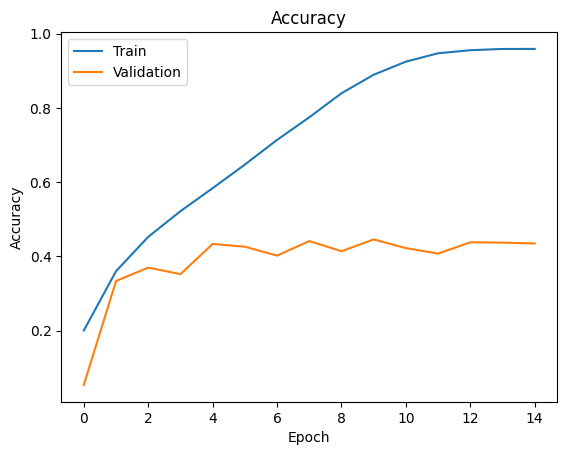

In [ ]:
show_results(base_model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

True Fine: sea
Predicted Fine: trout


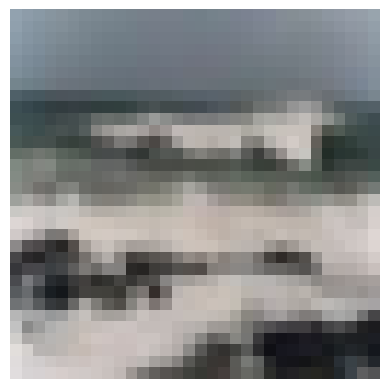

In [ ]:
random_predict(base_model)

## Experiments

In [ ]:
def model_builder(input_shape=(32, 32, 3), num_fine_classes=100, dropout_rate=0.0, num_blocks=3):
    name = f'model_b{num_blocks}_d{int(dropout_rate * 10)}'
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2)(x)
    filters = 64
    for i in range(num_blocks):
        stride = 2 if i > 0 else 1
        x = ResidualBlock(filters=filters, stride=stride)(x)
        filters *= 2
    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_fine_classes, activation='softmax', name='fine')(x)
    return Model(inputs=inputs, outputs=outputs, name=name)

def get_callbacks():
    return [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, mode='max')
    ]

def train(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_fine)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_fine)).batch(128)
    print(f"Training {model.name}...")
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=60,
        callbacks=get_callbacks(),
        verbose=0
    )
    test_result = model.evaluate(test_dataset, verbose=0)
    print(f"Test Accuracy: {test_result[1]*100:.2f}%")
    return history, test_result[1]

In [ ]:
dropouts = [0.0, 0.3, 0.5]
blocks = [1, 2, 3]
histories = {}
results = {}
models = {}

for d in dropouts:
    for b in blocks:
        model = model_builder(num_blocks=b, dropout_rate=d)
        models[model.name] = model
        histories[model.name], results[model.name] = train(model)

Training model_b1_d0...
Test Accuracy: 50.92%
Training model_b2_d0...
Test Accuracy: 52.21%
Training model_b3_d0...
Test Accuracy: 50.25%
Training model_b1_d3...
Test Accuracy: 44.88%
Training model_b2_d3...
Test Accuracy: 53.67%
Training model_b3_d3...
Test Accuracy: 48.80%
Training model_b1_d5...
Test Accuracy: 38.11%
Training model_b2_d5...
Test Accuracy: 50.59%
Training model_b3_d5...
Test Accuracy: 47.86%


model_b1_d0


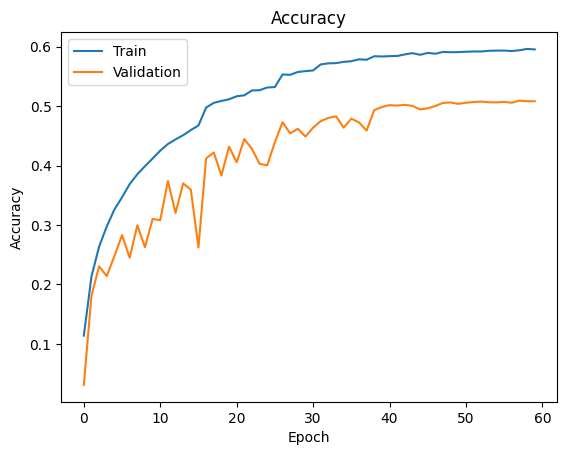

model_b2_d0


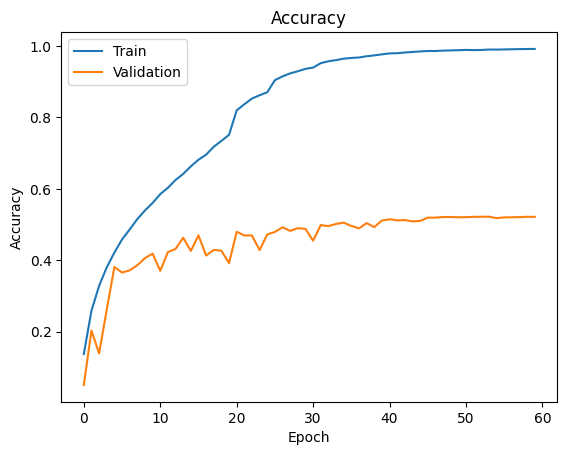

model_b3_d0


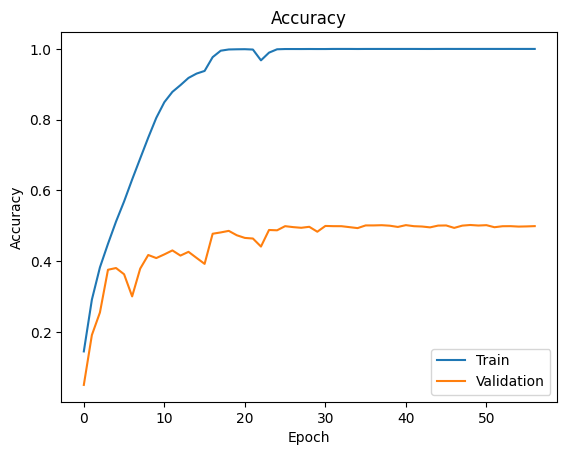

model_b1_d3


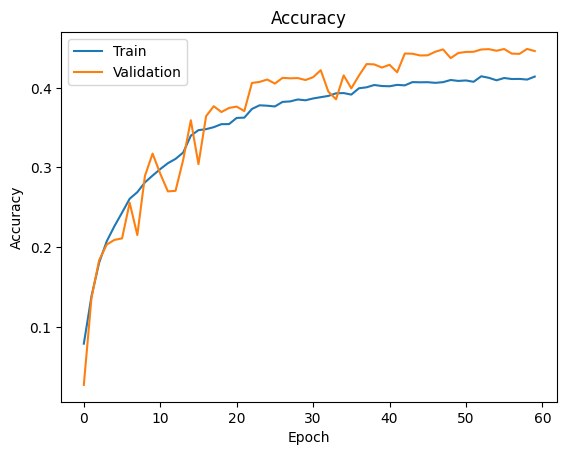

model_b2_d3


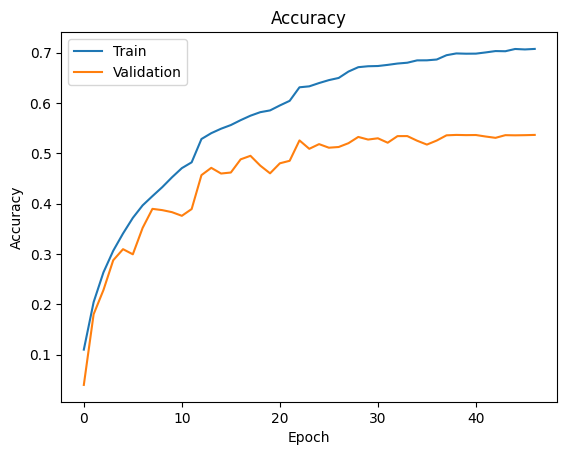

model_b3_d3


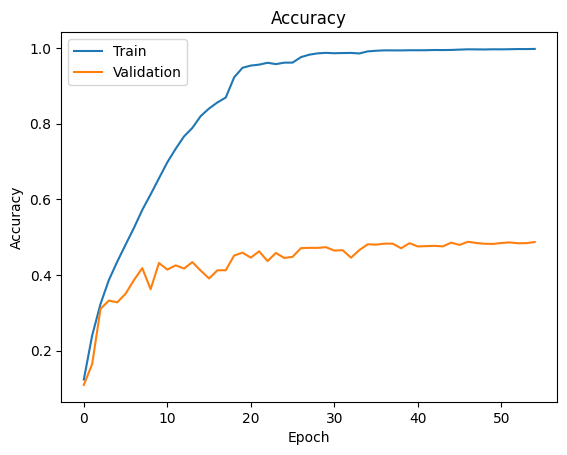

model_b1_d5


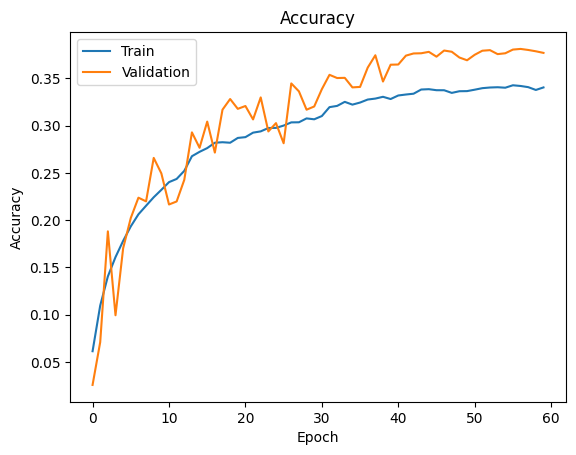

model_b2_d5


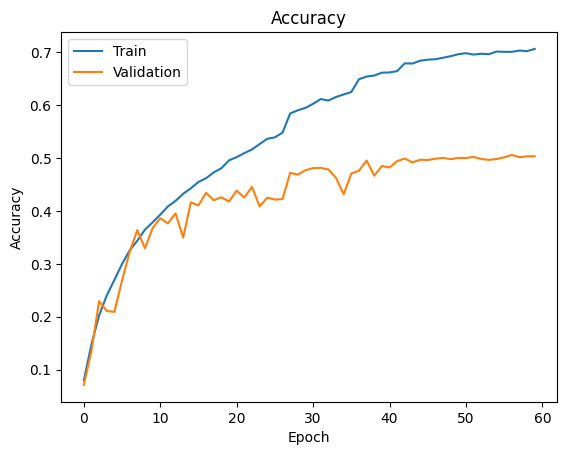

model_b3_d5


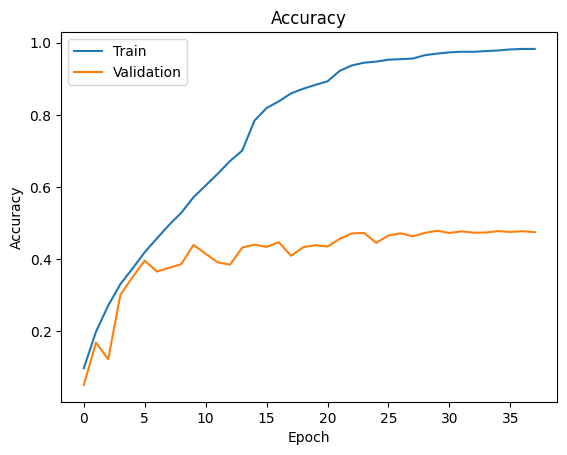

In [ ]:
for name, history in histories.items():
  print(name)
  show_results(history)

In [ ]:
def train_aug(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    datagen.fit(train_images)

    train_dataset = datagen.flow(train_images, train_fine, batch_size=128)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_fine)).batch(128)

    print(f"Training {model.name}...")
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=60,
        callbacks=get_callbacks(),
        verbose=0
    )
    test_result = model.evaluate(test_dataset, verbose=0)
    print(f"Test Accuracy: {test_result[1]*100:.2f}%")
    return history, test_result[1]

In [ ]:
dropouts = [0.0, 0.3, 0.5]

for d in dropouts:
    model = model_builder(dropout_rate=d)
    model.name += '_aug'
    models[model.name] = model
    histories[model.name], results[model.name] = train_aug(model)

Training model_b3_d0_aug...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 61.45%
Training model_b3_d3_aug...
Test Accuracy: 61.38%
Training model_b3_d5_aug...
Test Accuracy: 60.69%


model_b1_d0


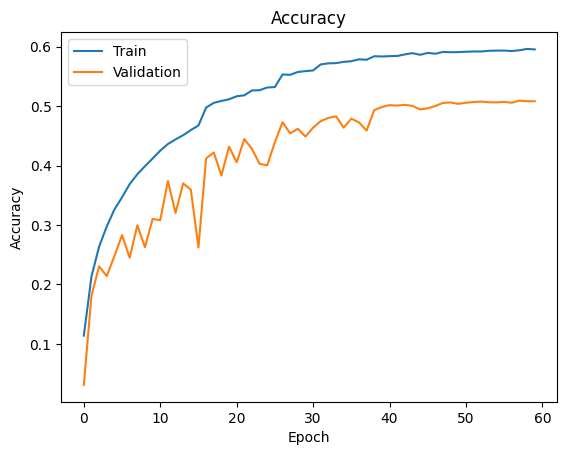

model_b2_d0


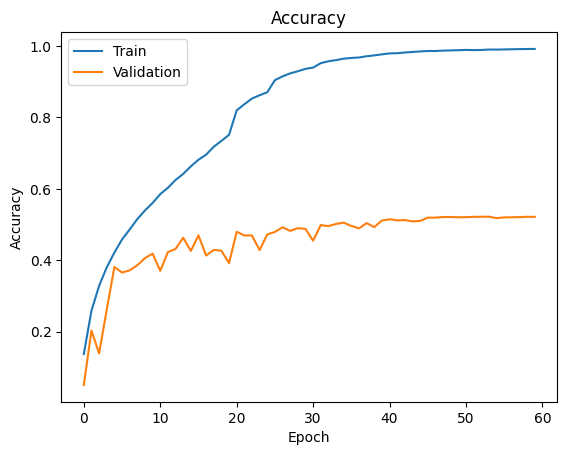

model_b3_d0


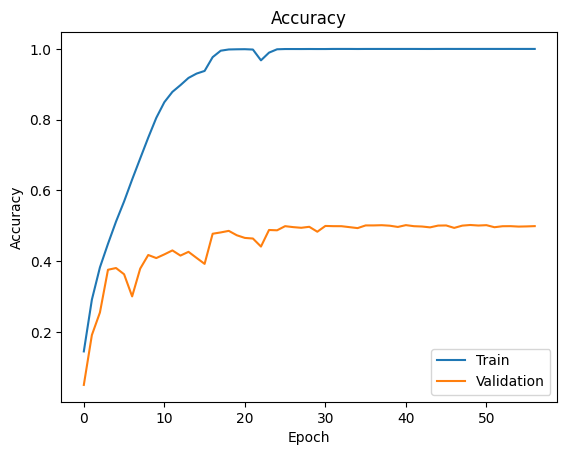

model_b1_d3


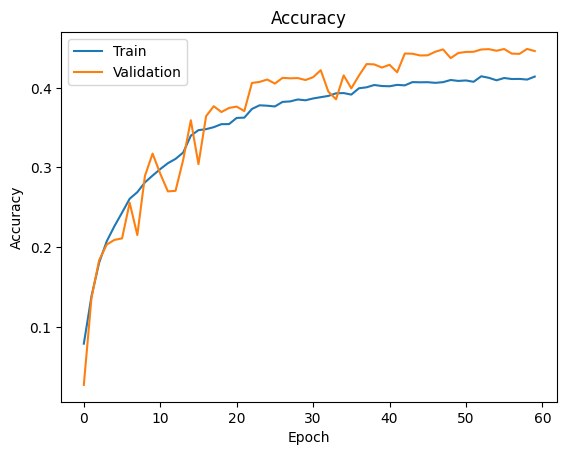

model_b2_d3


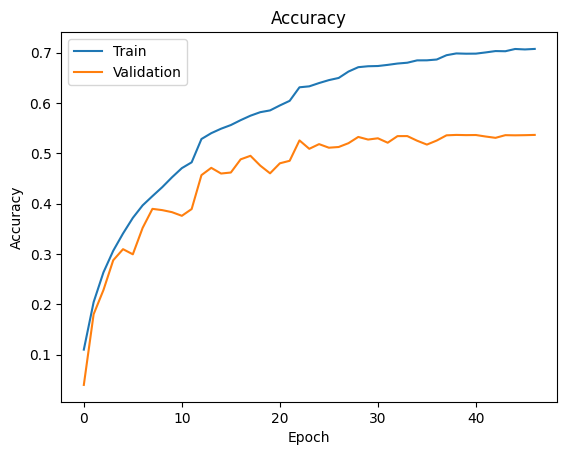

model_b3_d3


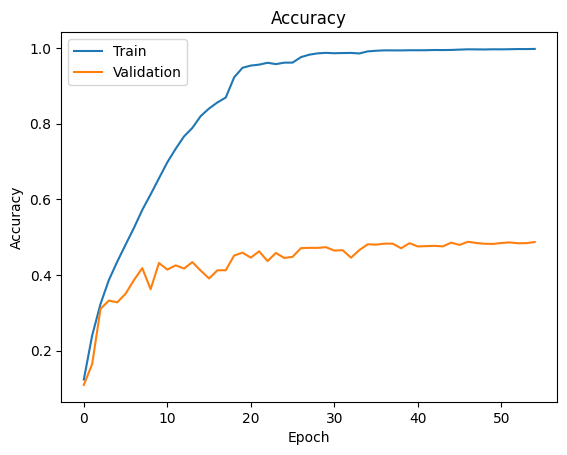

model_b1_d5


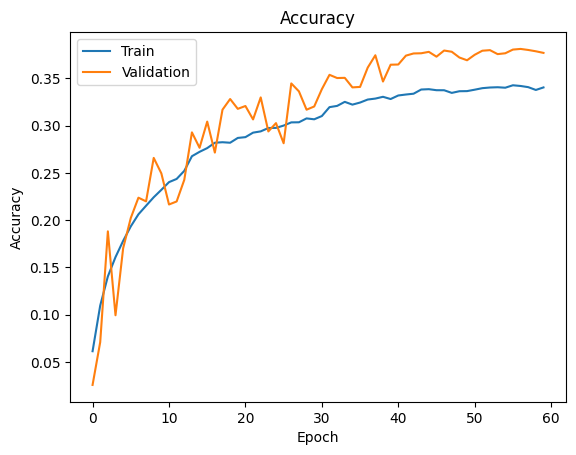

model_b2_d5


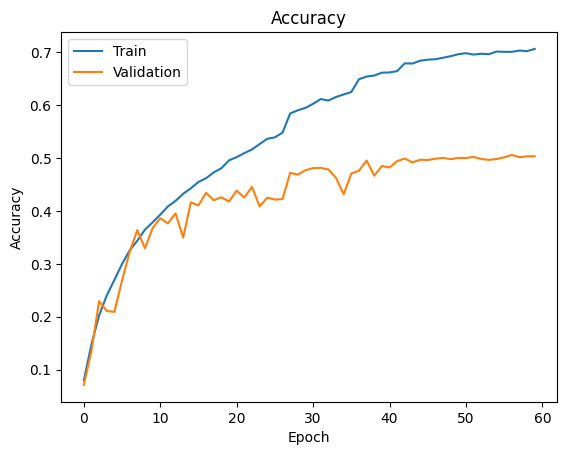

model_b3_d5


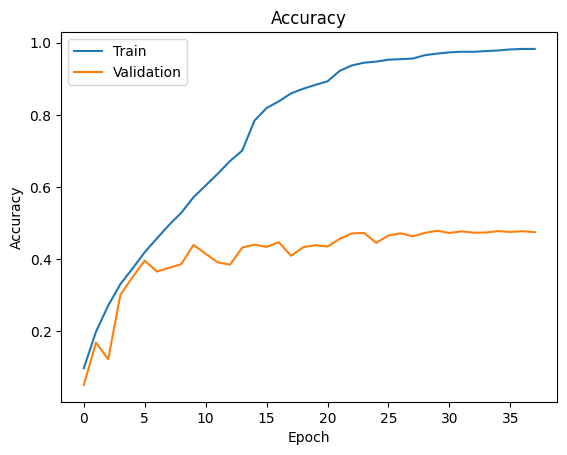

model_b3_d0_aug


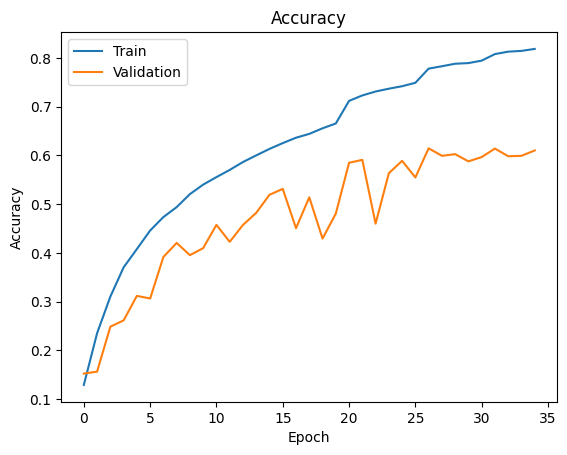

model_b3_d3_aug


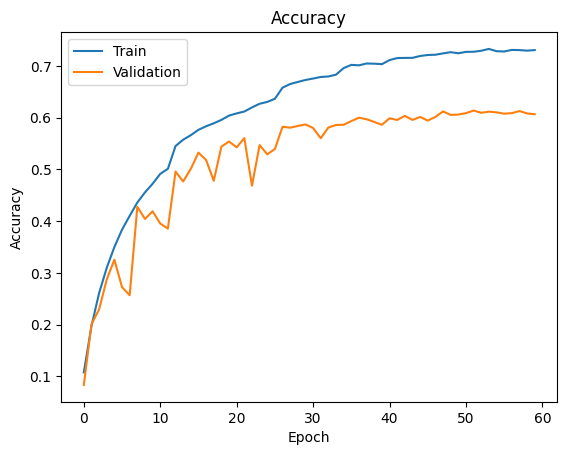

model_b3_d5_aug


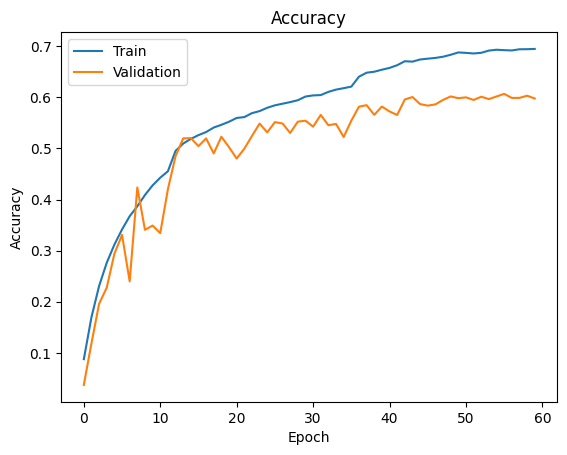

In [ ]:
for name, history in histories.items():
  print(name)
  show_results(history)

In [ ]:
for name, model in models.items():
 model.save(f'/content/models/{name}.h5')

# Convert to TensorFlow Lite

In [41]:
model = tf.keras.models.load_model(
    'models/model_b3_d0_aug.h5',
    custom_objects={'ResidualBlock': ResidualBlock}
)

In [42]:
model.trainable = False
for layer in model.layers:
    layer.trainable = False

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None, 32, 32, 3], dtype=tf.float32)])
def serving_fn(input):
    return model(input)

concrete_func = serving_fn.get_concrete_function()

tf.saved_model.save(
    model,
    'saved_model',
    signatures={'serving_default': concrete_func}
)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [44]:
f = tf.function(lambda x: model(x))
concrete_func = f.get_concrete_function(tf.TensorSpec([1, 32, 32, 3], tf.float32))
frozen_func = convert_variables_to_constants_v2(concrete_func)

In [45]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([frozen_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("frozen_model.tflite", "wb") as f:
    f.write(tflite_model)